# Correlation Between Numeric Variables
 
**Jakob Balkovec**  
Oct 2025

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

In [15]:
MASTER_CSV = Path(
  "/Users/jbalkovec/Desktop/MDR/Temporal/Pipeline/data/master/final_master_nonan.csv"
  )

In [16]:
df = pd.read_csv(MASTER_CSV)

numeric = df.select_dtypes(include="number")
corr = numeric.corr(method="spearman")

## Correlation Heatmap

I made a heatmap to see how all the variables relate to each other...things like temperature, moisture, and satellite features. I used Spearman correlation so it could catch both linear and monotonic trends.

As expected, the air and soil temperature values were strongly related, and all the soil-moisture layers were tightly connected too. Satellite features like NDVI and LST showed moderate links to ground measurements, which means they’re pretty solid proxies. Overall, the heatmap confirmed that most variables behave logically and group the way you’d expect.

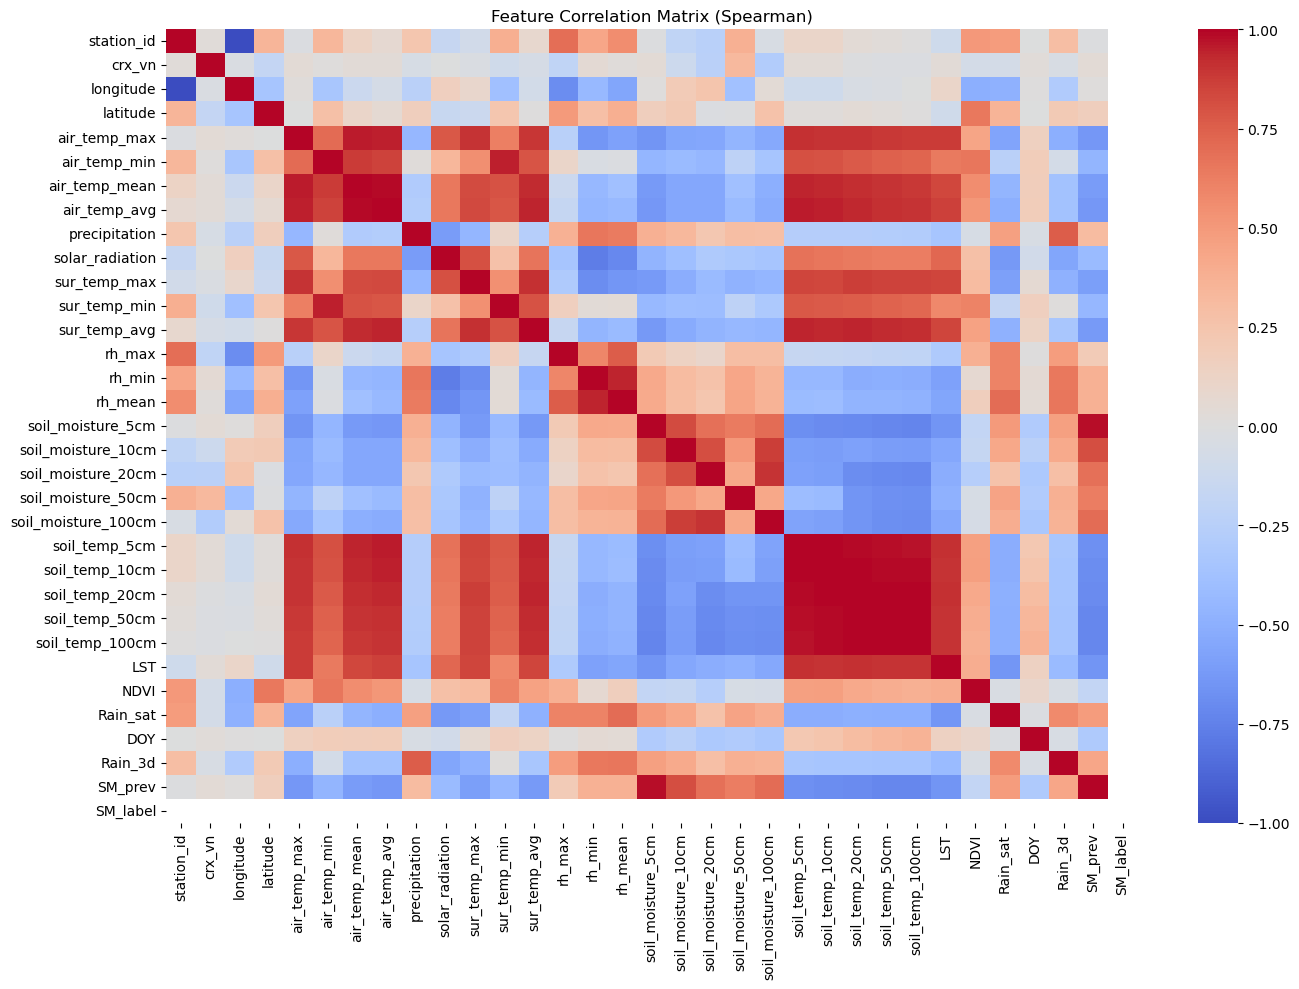

In [17]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Matrix (Spearman)")
plt.tight_layout()
plt.show()

### More Important Columns

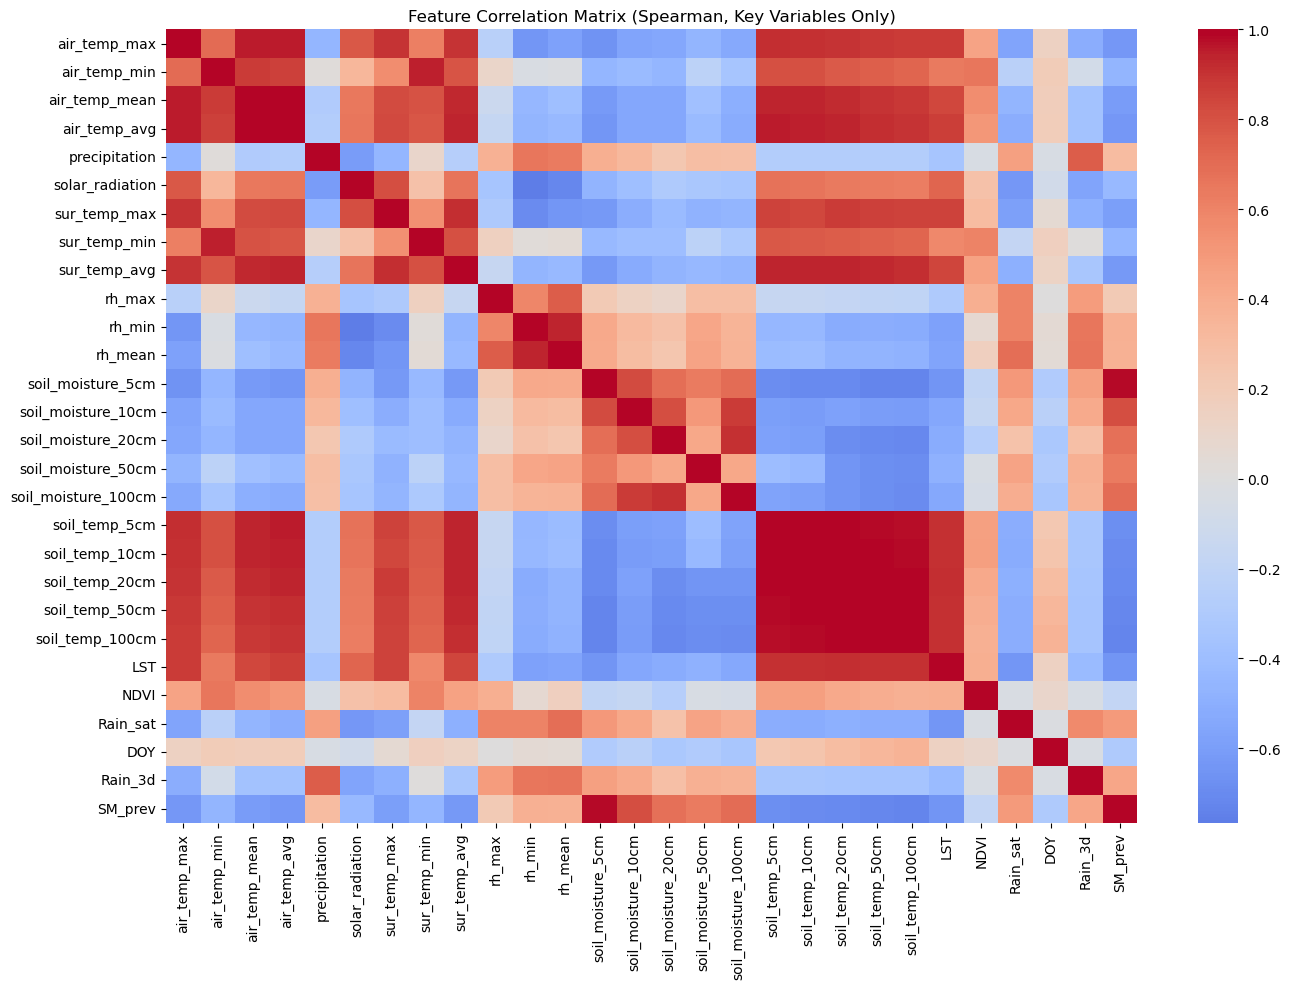

In [ ]:
drop_cols = [
    "date", "station_id", "source_file", "crx_vn",
    "longitude", "latitude", "sur_temp_type", "SM_label",
]

corr_df = df.drop(columns=drop_cols, errors="ignore")
corr = corr_df.corr(method="spearman")

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Matrix (Spearman, Key Variables Only)")
plt.tight_layout()
plt.show()

## Spearman Correlation Analysis

I ran pairwise Spearman correlations between the key environmental and satellite features to see how strongly they’re related beyond just linear patterns.

- LST vs. Soil Temperature (10 cm): ρ = 0.905 -> **very strong positive correlation**. Surface and subsurface temperatures move almost in sync.

- NDVI vs. Soil Moisture (10 cm): ρ = –0.169 ->  **weak negative correlation**, meaning greener vegetation doesn’t always correspond to wetter near-surface soil, possibly due to vegetation type or seasonal lag.

- Rain_sat vs. Precipitation: ρ = 0.466 -> **moderate positive correlation**, showing that satellite rainfall captures ground trends reasonably well but not perfectly.

- Air Temperature vs. LST: ρ = 0.836 -> **strong relationship**, confirming that ground air temperature closely follows satellite-observed surface heat.

- NDVI vs. Air Temperature: ρ = 0.541 -> **moderate positive correlation**, suggesting vegetation activity increases under warmer conditions.

Overall, the strongest relationships occur within thermal variables, while vegetation and moisture links are a little weaker but still meaningful...So basically, temperature features clearly move together and should be used side by side, while the NDVI–moisture relationship isn’t straightforward...it’ll probably need a nonlinear approach when modeling.

In [ ]:
variables = [
    ("LST", "soil_temp_10cm"),
    ("NDVI", "soil_moisture_10cm"),
    ("Rain_sat", "precipitation"),
    ("air_temp_mean", "LST"),
    ("NDVI", "air_temp_mean")
]

for x, y in variables:
    coef, p = spearmanr(df[x], df[y], nan_policy='omit')
    print(f"{x:<15} vs {y:<20} -> Spearman rho={coef:.3f}, p={p:.3e}")

LST             vs soil_temp_10cm       -> Spearman rho=0.905, p=0.000e+00
NDVI            vs soil_moisture_10cm   -> Spearman rho=-0.169, p=1.590e-98
Rain_sat        vs precipitation        -> Spearman rho=0.467, p=0.000e+00
air_temp_mean   vs LST                  -> Spearman rho=0.840, p=0.000e+00
NDVI            vs air_temp_mean        -> Spearman rho=0.555, p=0.000e+00


## PCA Projection (Explained Variance = 0.54)

I used PCA to check for redundancy and to see how much of the dataset’s variation could be captured in fewer dimensions. The first two components explained about 54% of the total variance.

The projection showed that while there’s some overlap between variables, there’s still unique information in each group. A 0.52 explained variance means a lot of features are correlated but not identical...so reducing dimensionality later (like feature grouping or selection) should help simplify things without losing too much signal.

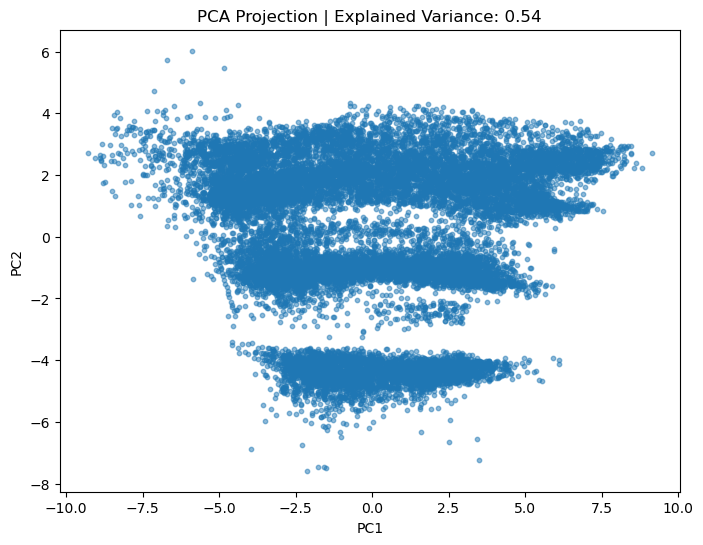

In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(numeric.fillna(0))

pca = PCA(n_components=2)
components = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(components[:,0], components[:,1], s=10, alpha=0.5)
plt.title(f"PCA Projection | Explained Variance: {pca.explained_variance_ratio_.sum():.2f}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Temporal Autocorrelation (Lag 1 = 0.985)

I checked how strongly soil moisture depends on its previous values using a one-day lag autocorrelation.

The correlation was 0.985, which is extremely high. That means soil moisture is heavily influenced by what it was the day before...basically, it doesn’t change fast. This makes a strong case for including lag features or using time-based models instead of treating each day as independent.

In [21]:
df = df.sort_values(["station_id", "date"])
df["SM_shift1"] = df.groupby("station_id")["soil_moisture_10cm"].shift(1)
corr = df[["soil_moisture_10cm", "SM_shift1"]].corr().iloc[0,1]
print(f"Temporal autocorrelation (lag 1): {corr:.3f}")

Temporal autocorrelation (lag 1): 0.985
